In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import tensorflow
tensorflow.compat.v1.disable_eager_execution()

# Why VAEs?

When using generative models, you could simply want to generate a random, new output, that looks similar to the training data, and you can certainly do that too with VAEs. But more often, you’d like to alter, or explore variations on data you already have, and not just in a random way either, but in a desired, specific direction. This is where VAEs work better than other method.

In the below example, we can see how the hypothetical embedding space for a standard autoencoder would look like

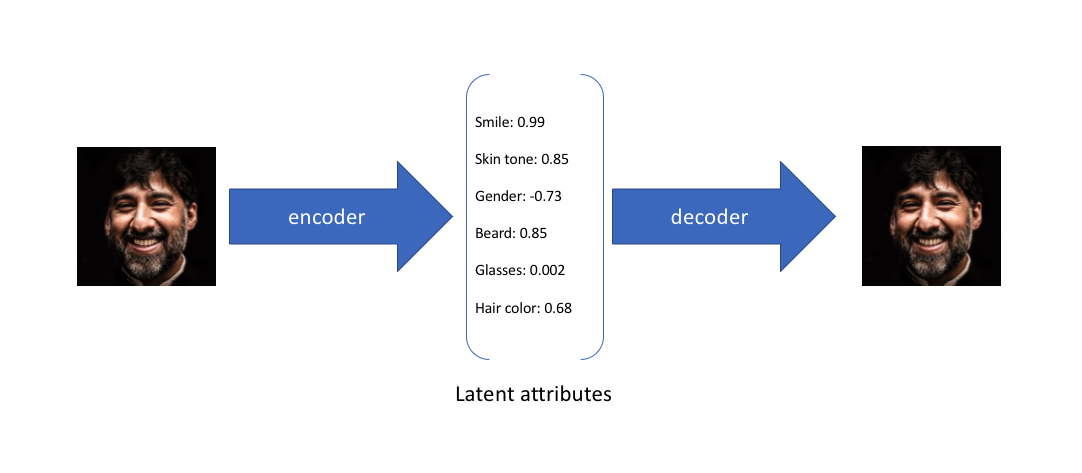



What if we wanted to generate new samples by modifying some attributes of a given sample as follows: 

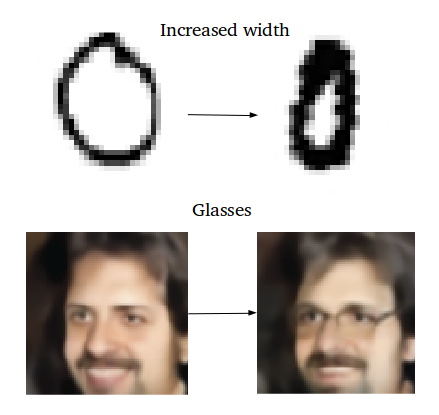

This is not possible with standard autoencoders since the embedding space is discrete as shown in the below figure:

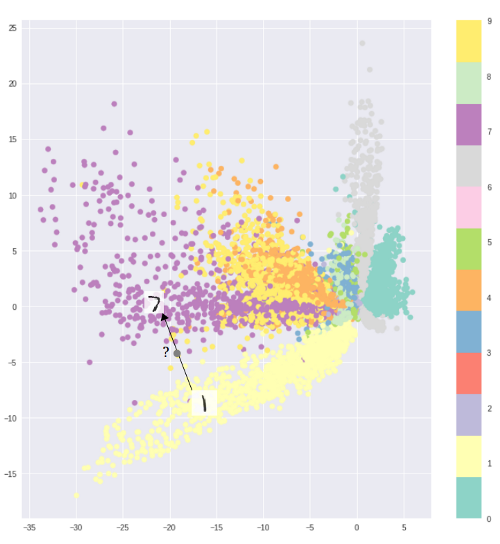

The fundamental problem with autoencoders, for generation, is that the latent space they convert their inputs to and where their encoded vectors lie, may not be continuous, or allow easy interpolation.

If the space has discontinuities (eg. gaps between clusters) and you sample/generate a variation from there, the decoder will simply generate an unrealistic output, because the decoder has no idea how to deal with that region of the latent space. During training, it never saw encoded vectors coming from that region of latent space.

This is where a variational autoencoder comes into the picture. Instead of using the encoder to predict a singular vector, we now predict a distribution (by predicting mean and std dev values for each of the units in the latent dimension). The decoder will now sample inputs from this distribution to decode. This makes the learned feature space continuous.

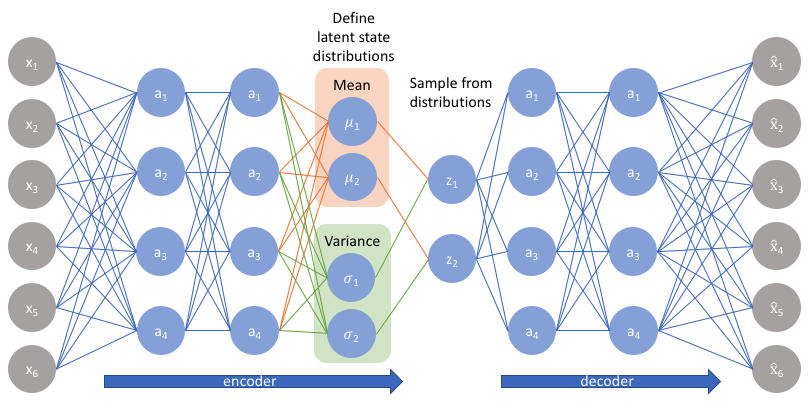

However, the question that now arises is that how to backpropogate while randomly sampling values through a distribution since gradients cannot be computed for random sampling. We overcome this issue using the reparameterization trick as shown below:

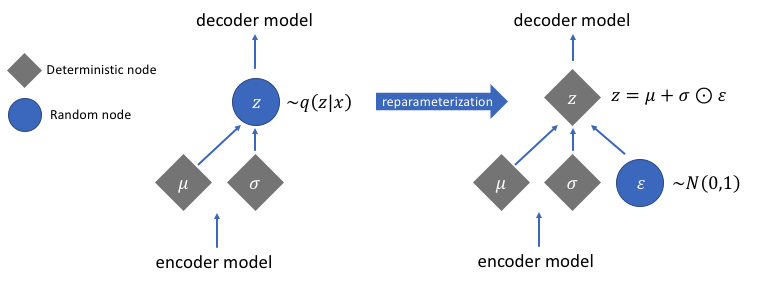

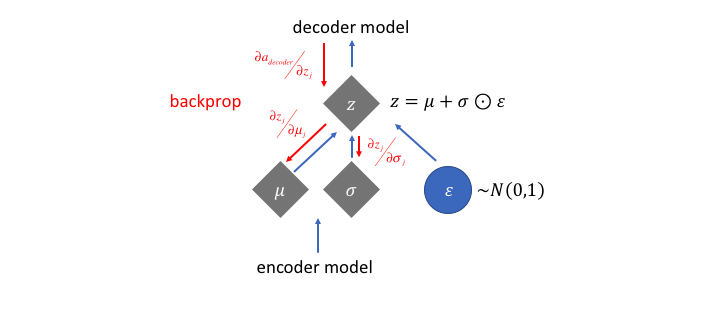

## Loss Function

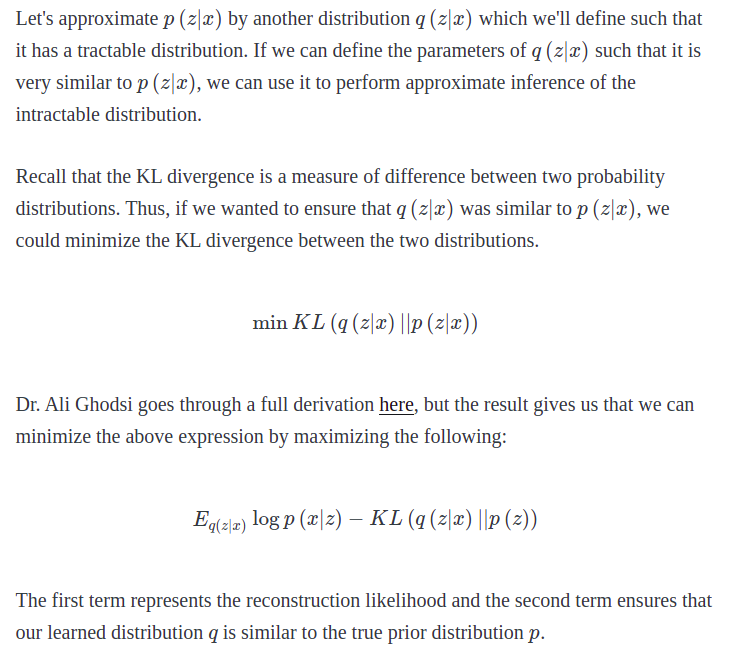

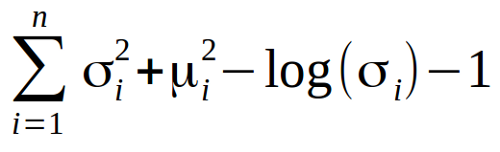

Link to derivation: https://youtu.be/uaaqyVS9-rM?t=19m42s

Finally, if we only use the standard reconstruction loss (MSE), the learned embedding spaces can be further away from each other thus reducing semantic meaning of generating new samples by modifying attributes.
This is why we use KL divergence. 

As we can see below, with the combination of reconstruction loss and KL divergence, the embedding spaces are both closer to each other and continuous. 

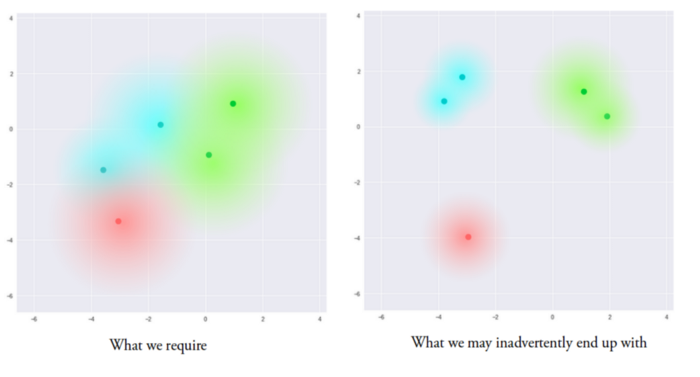

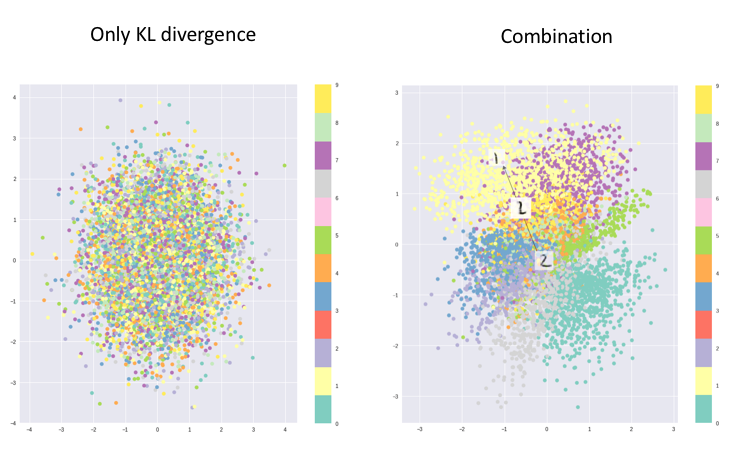

## Applications

Where to from here?
There are plenty of further improvements that can be made over the variational autoencoder. You could indeed, replace the standard fully-connected dense encoder-decoder with a convolutional-deconvolutional encoder-decoder pair, to produce great synthetic human face photos.

You could even train an autoencoder using LSTM encoder-decoder pairs (using a modified version of the seq2seq architecture) for sequential, discrete data (something not possible with methods such as GANs), to produce synthetic text, or even interpolate between MIDI samples such as Google Brain’s Magenta’s MusicVAE. Link: https://nips2017creativity.github.io/doc/Hierarchical_Variational_Autoencoders_for_Music.pdf



# Loading Dataset

Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


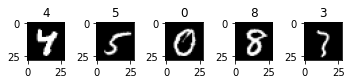

In [5]:
from tensorflow.keras.datasets import mnist

(trainX, trainy), (testX, testy) = mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testy.shape))

for j in range(5):
    i = np.random.randint(0, 10000)
    plt.subplot(550 + 1 + j)
    plt.imshow(trainX[i], cmap='gray')
    plt.title(trainy[i])
plt.show()

# Data Preparation

In [6]:
train_data = trainX.astype('float32')/255
test_data = testX.astype('float32')/255

train_data = np.reshape(train_data, (60000, 28, 28, 1))
test_data = np.reshape(test_data, (10000, 28, 28, 1))

print (train_data.shape, test_data.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


# VAE

## Encoder Part

In [7]:
import tensorflow

input_data = tensorflow.keras.layers.Input(shape=(784,))
encoder = tensorflow.keras.layers.Dense(512, activation='relu')(input_data)
encoder = tensorflow.keras.layers.Dense(16, activation='relu')(input_data)

# TODO: Homework
# input_data = tensorflow.keras.layers.Input(shape=(28, 28, 1))
# Add Conv and MaxPool layers here


# encoder = tensorflow.keras.layers.Flatten()(encoder)
# encoder = tensorflow.keras.layers.Dense(16)(encoder)

SyntaxError: ignored

## Latent Distribution and Sampling

In [ ]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tensorflow.shape(distribution_variance)[0]
    random = tensorflow.keras.backend.random_normal(shape=(batch_size, tensorflow.shape(distribution_variance)[1]))
    return distribution_mean + tensorflow.exp(0.5 * distribution_variance) * random

In [ ]:
distribution_mean = tensorflow.keras.layers.Dense(2, name='mean')(encoder)
distribution_variance = tensorflow.keras.layers.Dense(2, name='log_variance')(encoder)
latent_encoding = tensorflow.keras.layers.Lambda(sample_latent_features)([distribution_mean, distribution_variance])

In [ ]:
encoder_model = tensorflow.keras.Model(input_data, latent_encoding)
encoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16)           12560       input_1[0][0]                    
__________________________________________________________________________________________________
mean (Dense)                    (None, 2)            34          dense_1[0][0]                    
__________________________________________________________________________________________________
log_variance (Dense)            (None, 2)            34          dense_1[0][0]                    
______________________________________________________________________________________________

## Decoder Part

In [ ]:
decoder_input = tensorflow.keras.layers.Input(shape=(2))

# Comment out the next 3 lines for homework
decoder = tensorflow.keras.layers.Dense(16)(decoder_input)
decoder = tensorflow.keras.layers.Dense(512)(decoder)
decoder_output = tensorflow.keras.layers.Dense(784, activation='sigmoid')(decoder)

# TODO: Homework
# decoder = tensorflow.keras.layers.Dense(64)(decoder_input)
# decoder = tensorflow.keras.layers.Reshape((1, 1, 64))(decoder)

# Add conv transpose and upsampling2D layers after this: (Eg: decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder))


In [ ]:
decoder_model = tensorflow.keras.Model(decoder_input, decoder_output)
decoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_3 (Dense)              (None, 512)               8704      
_________________________________________________________________
dense_4 (Dense)              (None, 784)               402192    
Total params: 410,944
Trainable params: 410,944
Non-trainable params: 0
_________________________________________________________________


## Combining

In [ ]:
encoded = encoder_model(input_data)
decoded = decoder_model(encoded)

In [ ]:
autoencoder = tensorflow.keras.models.Model(input_data, decoded)

## Loss Function (Reconstruction Loss + KL-loss)

In [ ]:
def get_loss(distribution_mean, distribution_variance):
    
    def get_reconstruction_loss(y_true, y_pred):
        reconstruction_loss = tensorflow.keras.losses.mse(y_true, y_pred)
        reconstruction_loss_batch = tensorflow.reduce_mean(reconstruction_loss)
        return reconstruction_loss_batch*28*28
    
    def get_kl_loss(distribution_mean, distribution_variance):
        kl_loss = 1 + distribution_variance - tensorflow.square(distribution_mean) - tensorflow.exp(distribution_variance)
        kl_loss_batch = tensorflow.reduce_mean(kl_loss)
        return kl_loss_batch*(-0.5)
    
    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
        return reconstruction_loss_batch + kl_loss_batch
    
    return total_loss

## Training

In [ ]:
autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance), optimizer='adam')
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
model (Functional)           (None, 2)                 12628     
_________________________________________________________________
model_1 (Functional)         (None, 784)               410944    
Total params: 423,572
Trainable params: 423,572
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# TODO: For homework, comment out the next two line.
train_data = train_data.reshape(-1, 784)
test_data = test_data.reshape(-1, 784)

In [ ]:
autoencoder.fit(train_data, train_data, epochs=20, batch_size=64, validation_data=(test_data, test_data))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 11s 184us/sample - loss: 49.9528 - val_loss: 45.0731
Epoch 2/20
60000/60000 [==============================] - 3s 48us/sample - loss: 45.3399 - val_loss: 44.9682
Epoch 3/20
60000/60000 [==============================] - 3s 46us/sample - loss: 45.2465 - val_loss: 44.9046
Epoch 4/20
60000/60000 [==============================] - 3s 45us/sample - loss: 45.1880 - val_loss: 44.8477
Epoch 5/20
60000/60000 [==============================] - 3s 45us/sample - loss: 45.1472 - val_loss: 44.8116
Epoch 6/20
60000/60000 [==============================] - 3s 46us/sample - loss: 45.0683 - val_loss: 44.7985
Epoch 7/20
60000/60000 [==============================] - 3s 45us/sample - loss: 45.0152 - val_loss: 44.7881
Epoch 8/20
60000/60000 [==============================] - 3s 44us/sample - loss: 44.9759 - val_loss: 44.8030
Epoch 9/20
60000/60000 [==============================] - 3s 50us/sample - l

Real Test Images


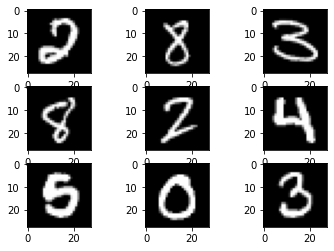

Reconstructed Images with Variational Autoencoder


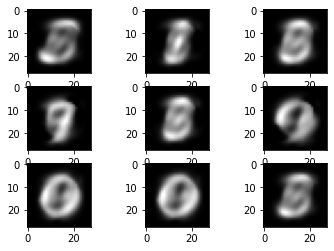

In [ ]:
offset=400
print ("Real Test Images")
# Real Images
for i in range(9):
    plt.subplot(330 + 1 + i)
    # plt.imshow(test_data[i+offset,:,:, -1], cmap='gray')
    reshaped_img = np.reshape(test_data[i+offset,:], (28, 28))
    plt.imshow(reshaped_img,  cmap='gray')
plt.show()

# Reconstructed Images
print ("Reconstructed Images with Variational Autoencoder")
for i in range(9):
    plt.subplot(330 + 1 + i)
    output = autoencoder.predict(np.array([test_data[i+offset]]))
    op_image = np.reshape(output[0]*255, (28, 28))
    plt.imshow(op_image, cmap='gray')
plt.show()

For convolutional VAEs, output will look something like this: 


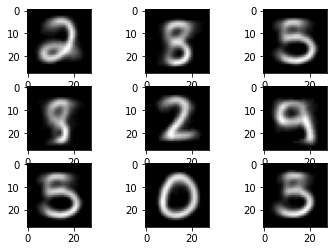

## Latent feature clusters

In [ ]:
x = []
y = []
z = []
for i in range(10000):
    z.append(testy[i])
    op = encoder_model.predict(np.array([test_data[i]]))
    x.append(op[0][0])
    y.append(op[0][1])

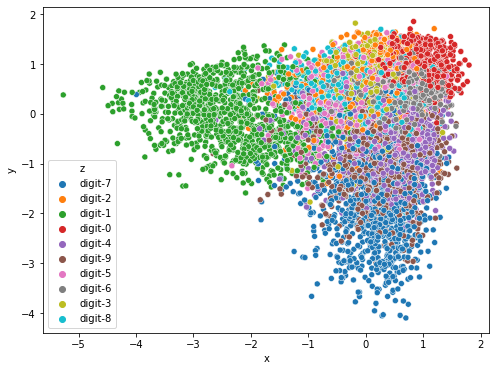

In [ ]:
df = pd.DataFrame()
df['x'] = x
df['y'] = y
df['z'] = ["digit-"+str(k) for k in z]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='x', y='y', hue='z', data=df)
plt.show()

## Image Generation

In [ ]:
generator_model = decoder_model

In [ ]:
x_values = np.linspace(-3, 3, 30)
y_values = np.linspace(-3, 3, 30)

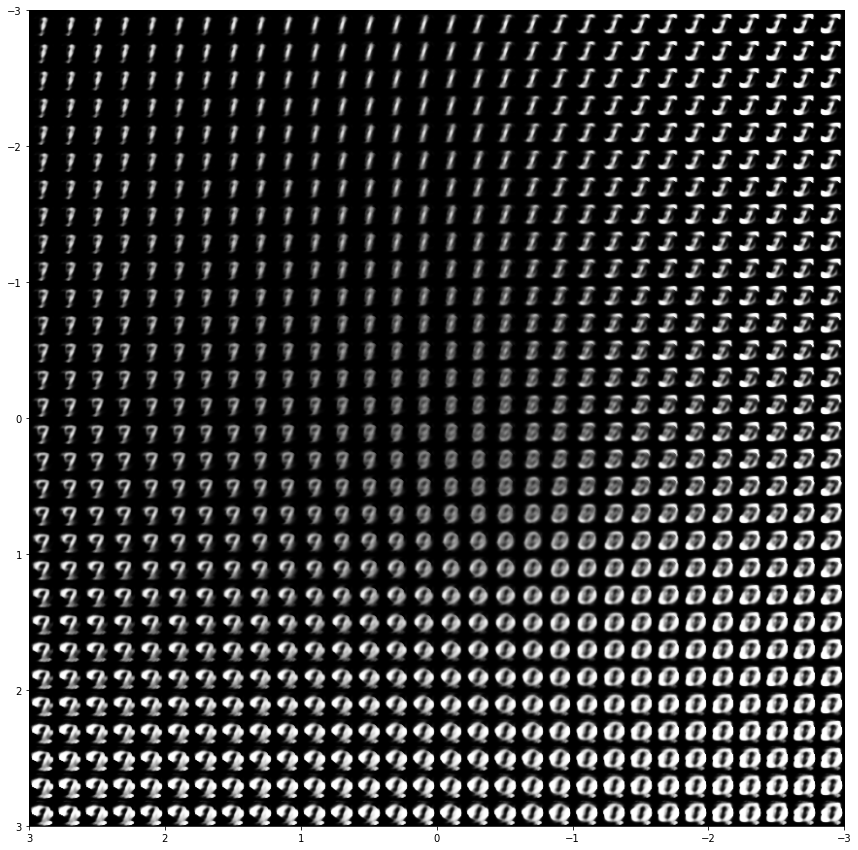

In [ ]:
figure = np.zeros((28 * 30, 28 * 30))
for ix, x in enumerate(x_values):
    for iy, y in enumerate(y_values):
        latent_point = np.array([[x, y]])
        generated_image = generator_model.predict(latent_point)[0]
        reshaped_img = np.reshape(generated_image, (28, 28))
        # figure[ix*28:(ix+1)*28, iy*28:(iy+1)*28,] = generated_image[:,:,-1]
        figure[ix*28:(ix+1)*28, iy*28:(iy+1)*28,] = reshaped_img
 
plt.figure(figsize=(15, 15))
plt.imshow(figure, cmap='gray', extent=[3,-3,3,-3])
plt.show()

For convolutional VAEs, output will look something like this:
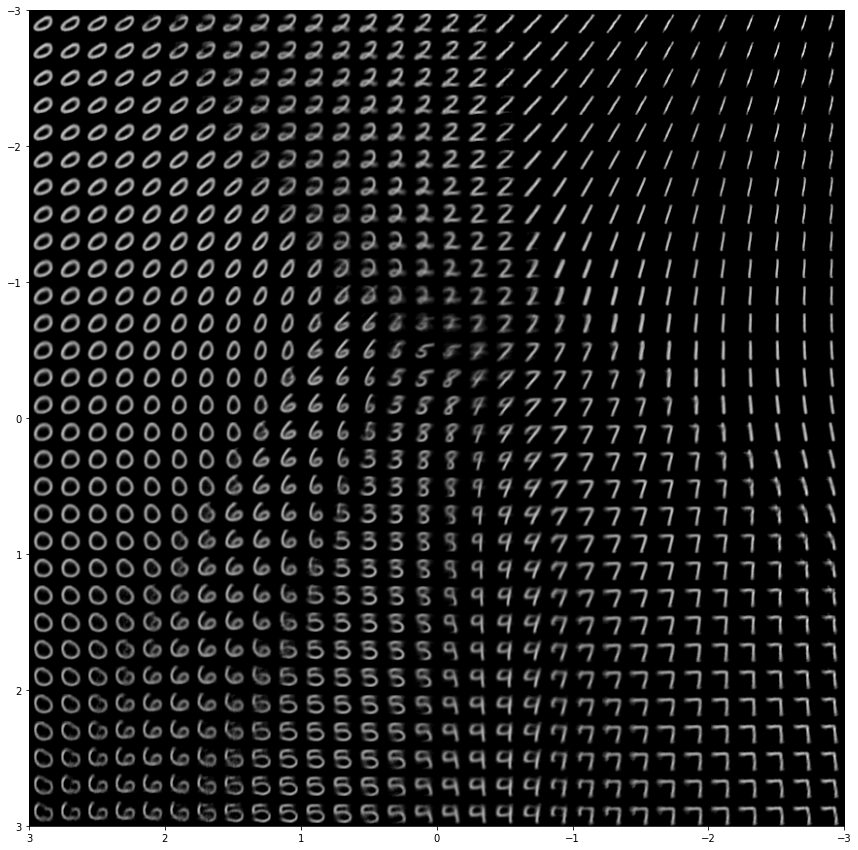

# Homework

Train a variational autoencoder on the Mnist and Fashion-Mnist datasets using a convolutional autoencoders instead of just dense layers and generate the latent embedding space and generated visualizations as shown in the above figures.


Ref: https://towardsdatascience.com/variational-autoencoders-as-generative-models-with-keras-e0c79415a7eb

References:

1. https://www.jeremyjordan.me/variational-autoencoders/
2. https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf
3. https://towardsdatascience.com/variational-autoencoders-as-generative-models-with-keras-e0c79415a7eb


In [1]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
(trainX, trainy), (testX, testy) = tf.keras.datasets.mnist.load_data()
trainX, trainy = np.expand_dims(trainX, -1)/255, np.expand_dims(trainy, -1)
testX, testy = np.expand_dims(testX, -1)/255, np.expand_dims(testy, -1)

In [3]:
input = tf.keras.layers.Input(shape=(28, 28, 1))
conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(input)
maxpool1 = tf.keras.layers.MaxPool2D((2,2))(conv1)
conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu')(maxpool1)
maxpool2 = tf.keras.layers.MaxPool2D((2,2))(conv2)
flatten = tf.keras.layers.Flatten()(maxpool2)
dense1 = tf.keras.layers.Dense(128, activation='relu')(flatten)
dense2 = tf.keras.layers.Dense(32, activation='relu')(dense1)

In [4]:
def probability(args):
    mean, log_var = args[0], args[1]
    rand = tf.keras.backend.random_normal(tf.shape(log_var))
    return mean + tf.exp(0.5*log_var)*rand

mean = tf.keras.layers.Dense(3)(dense2)
log_var = tf.keras.layers.Dense(3)(dense2)
z = tf.keras.layers.Lambda(probability)((mean, log_var))
model=tf.keras.models.Model(input, z)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 26, 26, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 13, 13, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 11, 11, 64)   18496       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [5]:
input_dec = tf.keras.layers.Input(3)
dense1_dec = tf.keras.layers.Dense(32, activation='relu')(input_dec)
dense2_dec = tf.keras.layers.Dense(128, activation='relu')(dense1_dec)
dense3_dec = tf.keras.layers.Dense(1600, activation='relu')(dense2_dec)
reshape = tf.keras.layers.Reshape((5, 5, 64))(dense3_dec)
up_samp1 = tf.keras.layers.UpSampling2D(size=(2,2))(reshape)
conv_dec1 = tf.keras.layers.Conv2DTranspose(kernel_size=(5,5), filters=1, activation='relu')(up_samp1)
up_samp2 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_dec1)
conv_dec2 = tf.keras.layers.Conv2DTranspose(kernel_size=(3,3), filters=1, activation='relu', padding='same')(up_samp2)
model_dec = tf.keras.models.Model(input_dec, conv_dec2)
model_dec.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                128       
_________________________________________________________________
dense_5 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_6 (Dense)              (None, 1600)              206400    
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 64)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 1)         1601

In [6]:
encoded = model(input)
decoded = model_dec(encoded) 
autoencoder = tf.keras.models.Model(input, decoded)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model (Functional)           (None, 3)                 228070    
_________________________________________________________________
model_1 (Functional)         (None, 28, 28, 1)         212363    
Total params: 440,433
Trainable params: 440,433
Non-trainable params: 0
_________________________________________________________________


In [7]:
def get_loss(distribution_mean, distribution_variance):
    
    def get_reconstruction_loss(y_true, y_pred):
        reconstruction_loss = tf.keras.losses.mse(y_true, y_pred)
        reconstruction_loss_batch = tf.reduce_mean(reconstruction_loss)
        print( reconstruction_loss_batch)
        return reconstruction_loss_batch*28*28
    
    def get_kl_loss(distribution_mean, distribution_variance):
        kl_loss = 1 + distribution_variance - tf.square(distribution_mean) - tf.exp(distribution_variance)
        kl_loss_batch = tf.reduce_mean(kl_loss)
        return kl_loss_batch*-0.5
    
    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
        return reconstruction_loss_batch + kl_loss_batch
    
    return total_loss

autoencoder.compile(optimizer='adam', loss=get_loss(mean, log_var))
autoencoder.fit(trainX, trainX, epochs=20, batch_size=64, validation_data=(testX, testX))

Tensor("loss/model_1_loss/Mean_1:0", shape=(), dtype=float32)
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 13s 213us/sample - loss: 40.7235 - val_loss: 34.0900
Epoch 2/20
60000/60000 [==============================] - 11s 177us/sample - loss: 32.7389 - val_loss: 31.6995
Epoch 3/20
60000/60000 [==============================] - 11s 177us/sample - loss: 31.0884 - val_loss: 30.4050
Epoch 4/20
60000/60000 [==============================] - 11s 177us/sample - loss: 30.0891 - val_loss: 29.9852
Epoch 5/20
60000/60000 [==============================] - 11s 176us/sample - loss: 29.4827 - val_loss: 29.1742
Epoch 6/20
60000/60000 [==============================] - 11s 176us/sample - loss: 28.9526 - val_loss: 28.9072
Epoch 7/20
60000/60000 [==============================] - 11s 177us/sample - loss: 28.5634 - val_loss: 28.4863
Epoch 8/20
60000/60000 [==============================] - 11s 177us/sample - loss: 28.2472 - val_loss: 28.1082


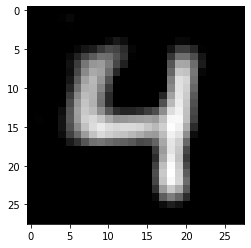

In [8]:
plt.imshow(autoencoder.predict(trainX[2:3]).reshape(28, 28), cmap='gray')

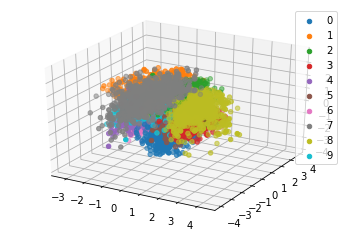

In [9]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
enc = model.predict(testX)
numbers = [[] for x in range(0, 10)]
for index, data in enumerate(enc):
    numbers[testy[index][0]].append(data)
numbers = np.array(numbers)
for x in range(0, 10):
    number = np.array(numbers[x])
    ax.scatter3D(number[:, 0], number[:,1], number[:, 2], label = x)
ax.legend(loc='best')

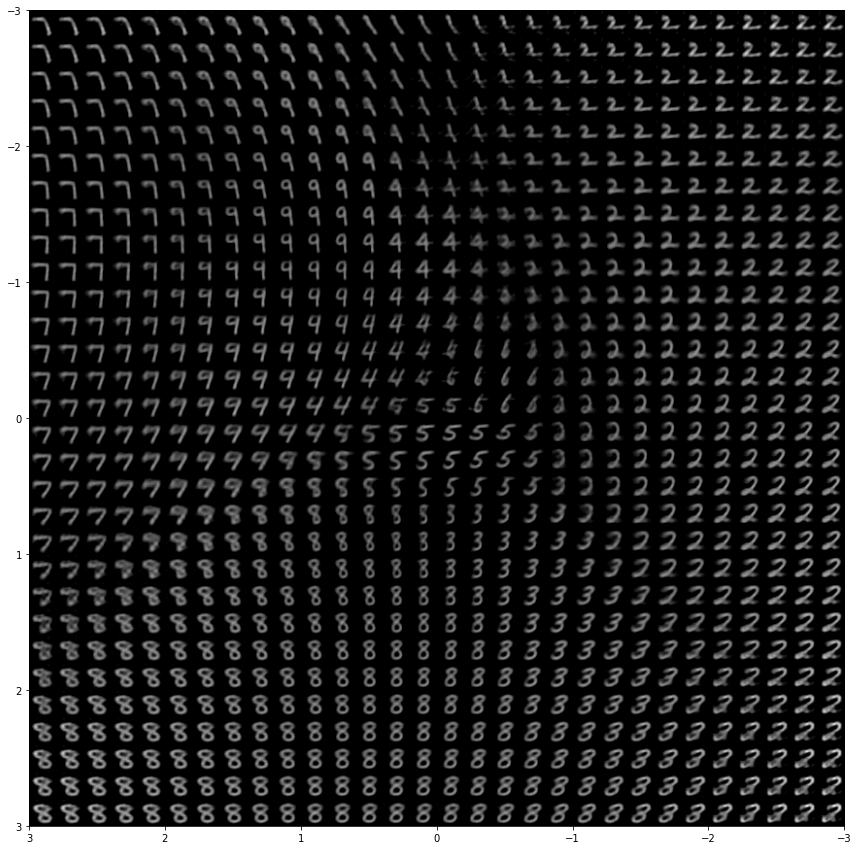

In [10]:
x_values = np.linspace(-3, 3, 30)
y_values = np.linspace(-3, 3, 30)
z_value = 0
figure = np.zeros((28 * 30, 28 * 30))
for ix, x in enumerate(x_values):
    for iy, y in enumerate(y_values):
        latent_point = np.array([[x, y, z_value]])
        generated_image = model_dec.predict(latent_point)[0]
        reshaped_img = np.reshape(generated_image, (28, 28))
        figure[ix*28:(ix+1)*28, iy*28:(iy+1)*28,] = reshaped_img
 
plt.figure(figsize=(15, 15))
plt.imshow(figure, cmap='gray', extent=[3,-3,3,-3])
plt.show()

In [11]:
#FASHION MNIST
(trainX, trainy), (testX, testy) = tf.keras.datasets.fashion_mnist.load_data()
trainX, trainy = np.expand_dims(trainX, -1)/255, np.expand_dims(trainy, -1)
testX, testy = np.expand_dims(testX, -1)/255, np.expand_dims(testy, -1)
autoencoder = tf.keras.models.Model(input, decoded)
autoencoder.summary()
autoencoder.compile(optimizer='adam', loss=get_loss(mean, log_var))
autoencoder.fit(trainX, trainX, epochs=20, batch_size=64, validation_data=(testX, testX))

4423680/4422102 [==============================] - 0s 0us/step
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model (Functional)           (None, 3)                 228070    
_________________________________________________________________
model_1 (Functional)         (None, 28, 28, 1)         212363    
Total params: 440,433
Trainable params: 440,433
Non-trainable params: 0
_________________________________________________________________
Tensor("loss_1/model_1_loss/Mean_1:0", shape=(), dtype=float32)
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 11s 188us/sample - loss: 28.5251 - val_loss: 23.9919
Epoch 2/20
60000/60000 [==============================] - 11s 177us/sample - loss: 23.3405 - va

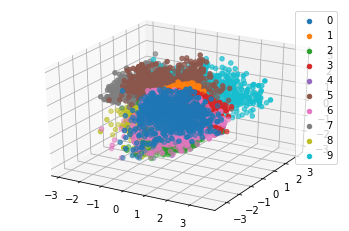

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
enc = model.predict(testX)
numbers = [[] for x in range(0, 10)]
for index, data in enumerate(enc):
    numbers[testy[index][0]].append(data)
numbers = np.array(numbers)
for x in range(0, 10):
    number = np.array(numbers[x])
    ax.scatter3D(number[:, 0], number[:,1], number[:, 2], label = x)
ax.legend(loc='best')

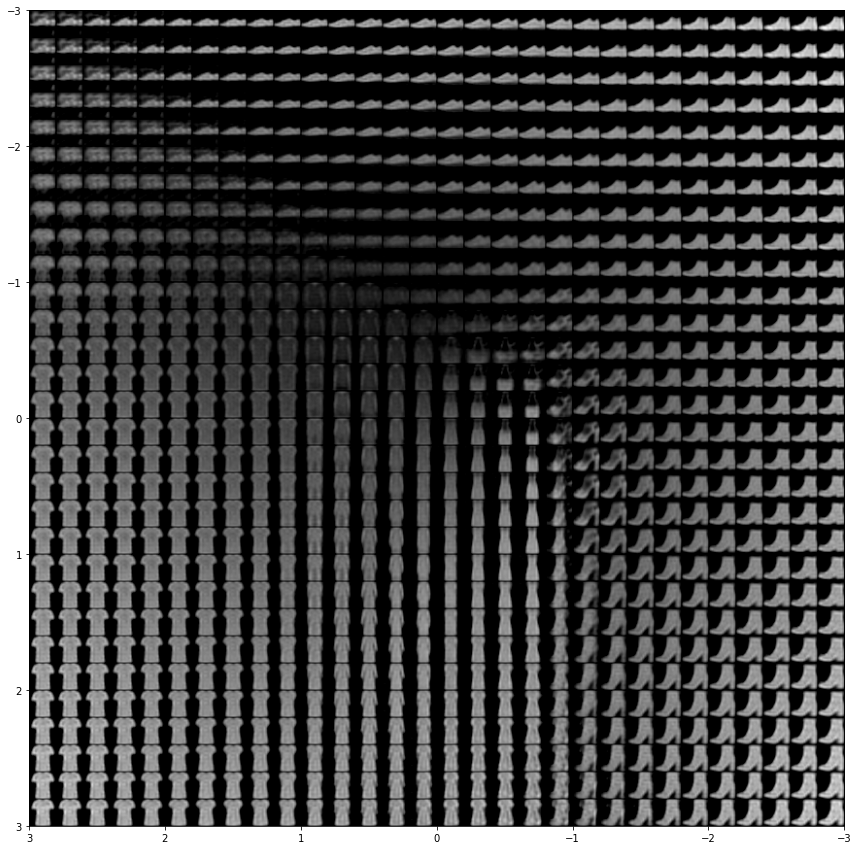

In [13]:
x_values = np.linspace(-3, 3, 30)
y_values = np.linspace(-3, 3, 30)
z_value = 0
figure = np.zeros((28 * 30, 28 * 30))
for ix, x in enumerate(x_values):
    for iy, y in enumerate(y_values):
        latent_point = np.array([[x, y, z_value]])
        generated_image = model_dec.predict(latent_point)[0]
        reshaped_img = np.reshape(generated_image, (28, 28))
        figure[ix*28:(ix+1)*28, iy*28:(iy+1)*28,] = reshaped_img
 
plt.figure(figsize=(15, 15))
plt.imshow(figure, cmap='gray', extent=[3,-3,3,-3])
plt.show()